# Predicting Health Costs in African Contexts

I've built this model to predict health insurance costs based on personal health factors, focusing on an African context simulation. My goal is to help raise awareness about how lifestyle choices and demographic factors influence medical expenses.

In [1]:
# Importing my libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# Setting my random seed for consistent results
np.random.seed(42)

## Getting to Know My Dataset

In [2]:
# Loading my dataset
df = pd.read_csv('insurance.csv')

# Let's see what we're working with
print("Dataset Preview:")
df.head()

Dataset Preview:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Checking dataset structure
print("\nDataset Information:")
df.info()

# Making sure there are no missing values
print("\nMissing Values:")
df.isnull().sum()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Missing Values:


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
# Getting statistical insights
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Visualizing Health Cost Patterns

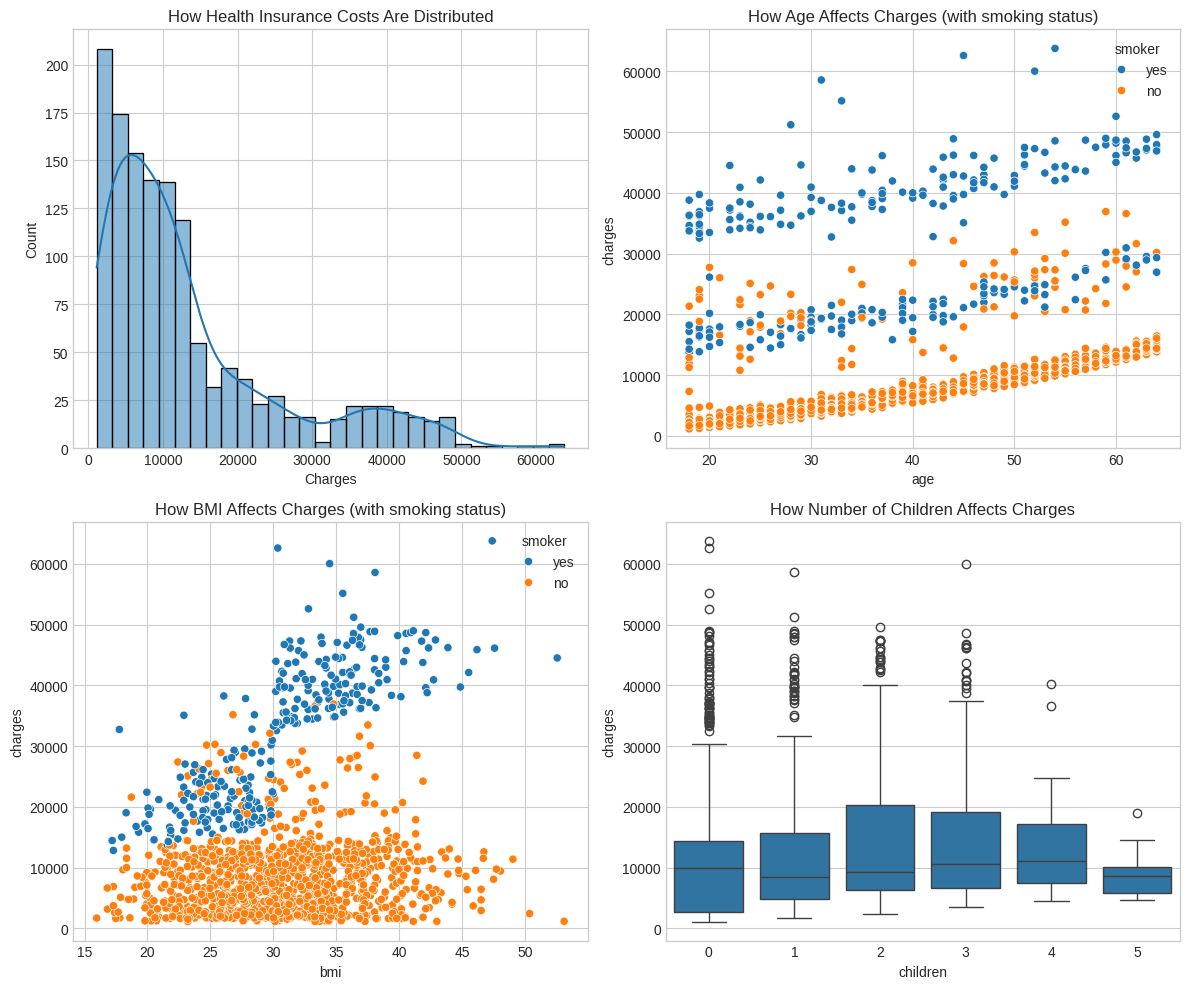

In [5]:
# Setting up my visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))

# Looking at the distribution of charges
plt.subplot(2, 2, 1)
sns.histplot(df['charges'], kde=True)
plt.title('How Health Insurance Costs Are Distributed')
plt.xlabel('Charges')

# Examining age impact
plt.subplot(2, 2, 2)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.title('How Age Affects Charges (with smoking status)')

# Examining BMI impact
plt.subplot(2, 2, 3)
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')
plt.title('How BMI Affects Charges (with smoking status)')

# Examining children impact
plt.subplot(2, 2, 4)
sns.boxplot(x='children', y='charges', data=df)
plt.title('How Number of Children Affects Charges')

plt.tight_layout()
plt.show()

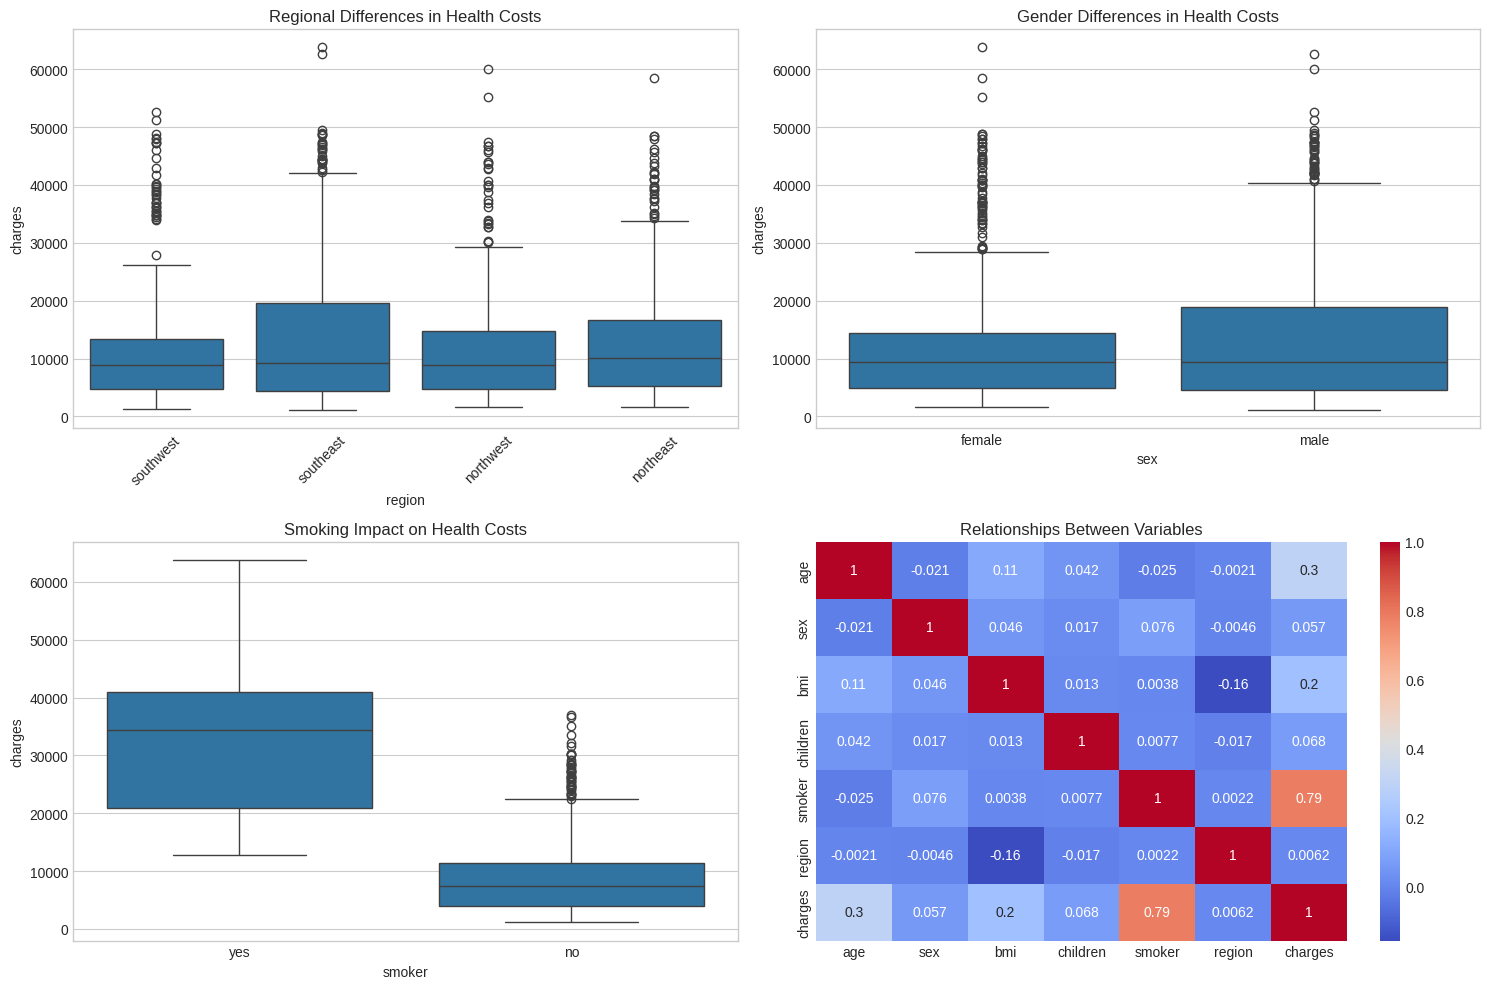

In [6]:
# More visualizations to understand the data better
plt.figure(figsize=(15, 10))

# Regional differences
plt.subplot(2, 2, 1)
sns.boxplot(x='region', y='charges', data=df)
plt.title('Regional Differences in Health Costs')
plt.xticks(rotation=45)

# Gender differences
plt.subplot(2, 2, 2)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Gender Differences in Health Costs')

# Smoking impact
plt.subplot(2, 2, 3)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Smoking Impact on Health Costs')

# Correlation heatmap
plt.subplot(2, 2, 4)
# Converting categorical variables to numeric for correlation
df_corr = df.copy()
df_corr['sex'] = df_corr['sex'].map({'female': 0, 'male': 1})
df_corr['smoker'] = df_corr['smoker'].map({'no': 0, 'yes': 1})
df_corr['region'] = pd.factorize(df_corr['region'])[0]
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Relationships Between Variables')

plt.tight_layout()
plt.show()

### What My Visualizations Tell Me

Looking at these charts, I can see several important patterns:

1. **Charges Distribution**: Most people have lower charges, but there's a long tail of high-cost individuals - this skewed distribution is typical in healthcare costs.

2. **Age Factor**: There's a clear upward trend between age and charges - as people get older, their healthcare costs tend to increase.

3. **BMI Impact**: Higher BMI correlates with higher charges, especially for smokers - this shows how multiple risk factors compound.

4. **Smoking Effect**: This is dramatic! Smokers consistently have much higher charges than non-smokers across all demographics.

5. **Children Factor**: Having children affects costs, but not as strongly as other factors.

6. **Regional Variations**: There are some cost differences between regions, but they're less significant than lifestyle factors.

7. **Gender Differences**: Surprisingly, there's not much difference in costs between males and females.

8. **Key Correlations**: The heatmap confirms that smoking status and age have the strongest relationships with charges.

These insights are particularly relevant for African healthcare contexts, where understanding cost drivers can help design better health education programs and insurance systems. The smoking impact could inform targeted public health campaigns, while age-related cost patterns might guide healthcare financing strategies.

## Creating Smarter Features

In [7]:
# Creating more insightful features based on my domain knowledge
df_engineered = df.copy()

# Converting categorical variables to numeric for feature engineering
df_engineered['sex_numeric'] = df_engineered['sex'].map({'female': 0, 'male': 1})
df_engineered['smoker_numeric'] = df_engineered['smoker'].map({'no': 0, 'yes': 1})

# Creating interaction terms - these capture combined effects
df_engineered['smoker_bmi'] = df_engineered['smoker_numeric'] * df_engineered['bmi']
df_engineered['smoker_age'] = df_engineered['smoker_numeric'] * df_engineered['age']

# Creating polynomial feature for BMI (bmi^2) to capture non-linear relationships
df_engineered['bmi_squared'] = df_engineered['bmi'] ** 2

# Checking out my new features
print("My Engineered Features:")
df_engineered[['age', 'bmi', 'smoker', 'smoker_bmi', 'smoker_age', 'bmi_squared', 'charges']].head()

My Engineered Features:


,age,bmi,smoker,smoker_bmi,smoker_age,bmi_squared,charges
0,19,27.900,yes,27.9,19,778.410000,16884.92400
1,18,33.770,no,0.0,0,1140.412900,1725.55230
2,28,33.000,no,0.0,0,1089.000000,4449.46200
3,33,22.705,no,0.0,0,515.517025,21984.47061
4,32,28.880,no,0.0,0,834.054400,3866.85520


In [8]:
print(df_engineered.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'sex_numeric', 'smoker_numeric', 'smoker_bmi', 'smoker_age',
       'bmi_squared'],
      dtype='object')


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Define Features (X) and Target (y)
# CORRECTED: 'region_numeric' has been removed from the list.
features = [
    'age', 
    'bmi', 
    'children', 
    'smoker_numeric', 
    'sex_numeric', 
    # 'region_numeric', # This was the cause of the error
    'smoker_age', 
    'smoker_bmi', 
    'bmi_squared'
]
X = df_engineered[features]
y = df_engineered['charges']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print("-" * 30)

# 3. Train the Linear Regression model
model_engineered = LinearRegression()
model_engineered.fit(X_train, y_train)
print("Model training complete.")
print("-" * 30)

# 4. Evaluate the model
y_pred = model_engineered.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Model Evaluation with Engineered Features:")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Data split into training and testing sets.
Training set size: 1070 samples
Test set size: 268 samples
------------------------------
Model training complete.
------------------------------
Model Evaluation with Engineered Features:
R-squared (R²): 0.8650
Mean Absolute Error (MAE): 2781.16
Mean Squared Error (MSE): 20956354.97
Root Mean Squared Error (RMSE): 4577.81


In [10]:
import pickle

# Define the filename for our model
model_filename = 'insurance_cost_model.pkl'

# Open the file in write-binary mode and save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model_engineered, file)

print(f"Model saved successfully to '{model_filename}'")

Model saved successfully to 'insurance_cost_model.pkl'


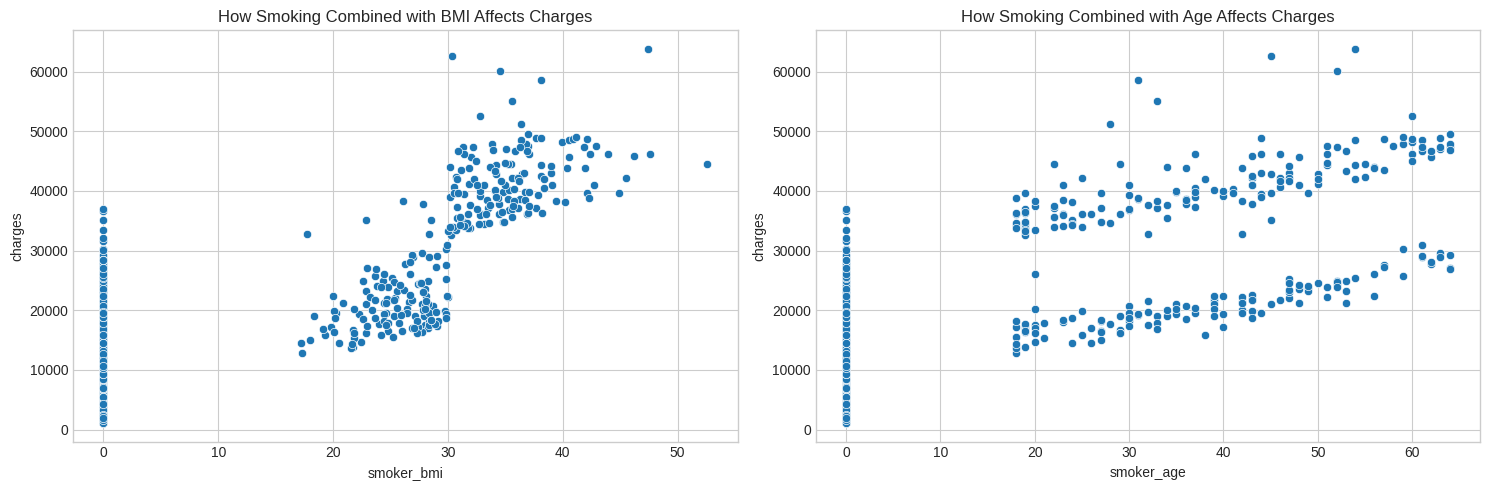

In [11]:
# Visualizing how my new interaction features relate to charges
plt.figure(figsize=(15, 5))

# Smoker*BMI interaction
plt.subplot(1, 2, 1)
sns.scatterplot(x='smoker_bmi', y='charges', data=df_engineered)
plt.title('How Smoking Combined with BMI Affects Charges')

# Smoker*Age interaction
plt.subplot(1, 2, 2)
sns.scatterplot(x='smoker_age', y='charges', data=df_engineered)
plt.title('How Smoking Combined with Age Affects Charges')

plt.tight_layout()
plt.show()

In [12]:
# Preparing my data for modeling
X = df_engineered.drop(['charges', 'sex_numeric', 'smoker_numeric'], axis=1)
y = df_engineered['charges']

# Organizing my features by type
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children', 'smoker_bmi', 'smoker_age', 'bmi_squared']

# Setting up preprocessing for different feature types
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
numerical_transformer = StandardScaler()

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building My Prediction Models

In [13]:
# Helper function to evaluate my models consistently
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Making predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculating performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training MSE: {train_mse:.2f}")
    print(f"Testing MSE: {test_mse:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    return train_mse, test_mse, train_r2, test_r2

### Model 1: Standard Linear Regression

In [14]:
# Building my linear regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

# Training the model
lr_pipeline.fit(X_train, y_train)

# Checking how well it performs
print("My Linear Regression Results:")
lr_train_mse, lr_test_mse, lr_train_r2, lr_test_r2 = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test)

My Linear Regression Results:
Training MSE: 23776992.30
Testing MSE: 20637104.26
Training R²: 0.8353
Testing R²: 0.8671


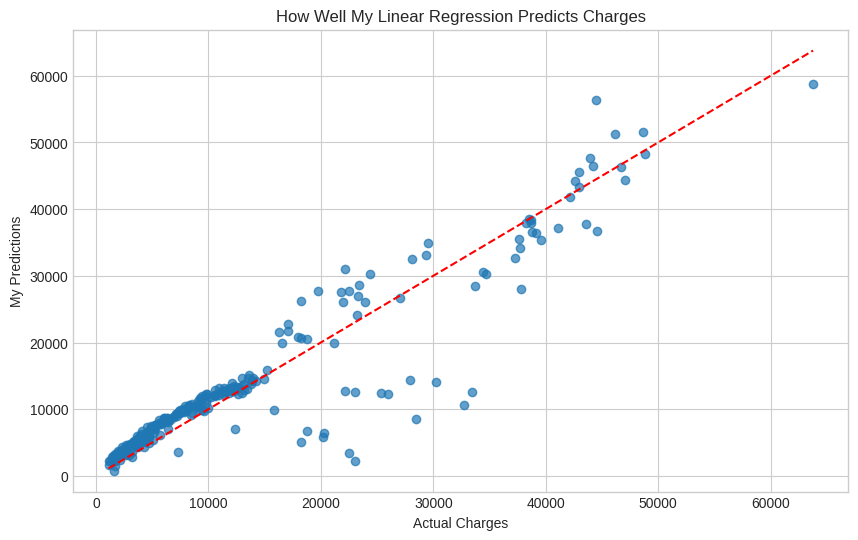

In [15]:
# Visualizing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pipeline.predict(X_test), alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('My Predictions')
plt.title('How Well My Linear Regression Predicts Charges')
plt.show()

### Model 2: Gradient Descent Linear Regression

In [16]:
# Building my SGD regressor pipeline with early stopping
sgd_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42, 
                                                         early_stopping=True, validation_fraction=0.1))])

# Training the model
sgd_pipeline.fit(X_train, y_train)

# Checking how well it performs
print("My SGD Regressor Results:")
sgd_train_mse, sgd_test_mse, sgd_train_r2, sgd_test_r2 = evaluate_model(sgd_pipeline, X_train, X_test, y_train, y_test)

My SGD Regressor Results:
Training MSE: 27953417.46
Testing MSE: 24353995.29
Training R²: 0.8063
Testing R²: 0.8431


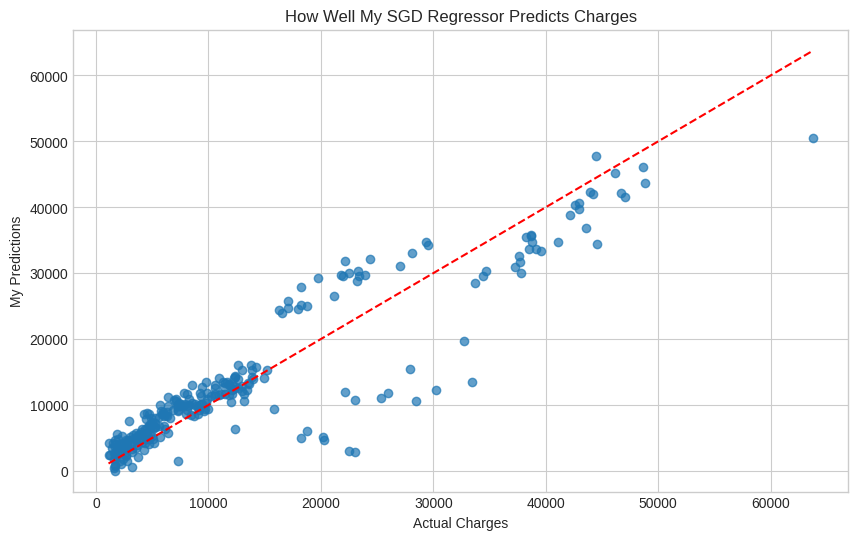

In [17]:
# Visualizing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, sgd_pipeline.predict(X_test), alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('My Predictions')
plt.title('How Well My SGD Regressor Predicts Charges')
plt.show()

In [18]:
# Tracking learning progress with custom SGD implementation
# (sklearn's SGDRegressor doesn't show loss curves directly)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Setting up my custom SGD training
sgd_custom = SGDRegressor(max_iter=1, tol=None, warm_start=True, random_state=42)

# Training with manual epochs to track learning progress
n_epochs = 100
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    sgd_custom.partial_fit(X_train_processed, y_train)
    
    # Tracking training error
    y_train_pred = sgd_custom.predict(X_train_processed)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_mse)
    
    # Tracking test error
    y_test_pred = sgd_custom.predict(X_test_processed)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_mse)
    
    # Showing progress updates
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")

Epoch 10/100, Train MSE: 28710616.86, Test MSE: 25140410.29
Epoch 20/100, Train MSE: 27426929.71, Test MSE: 23578718.46
Epoch 30/100, Train MSE: 26912343.66, Test MSE: 22966596.22
Epoch 40/100, Train MSE: 26608902.93, Test MSE: 22630163.85
Epoch 50/100, Train MSE: 26387687.52, Test MSE: 22404705.18
Epoch 60/100, Train MSE: 26207655.72, Test MSE: 22234515.96
Epoch 70/100, Train MSE: 26052765.39, Test MSE: 22096570.07
Epoch 80/100, Train MSE: 25915553.99, Test MSE: 21979784.85
Epoch 90/100, Train MSE: 25791968.64, Test MSE: 21878137.87
Epoch 100/100, Train MSE: 25679499.73, Test MSE: 21788020.23


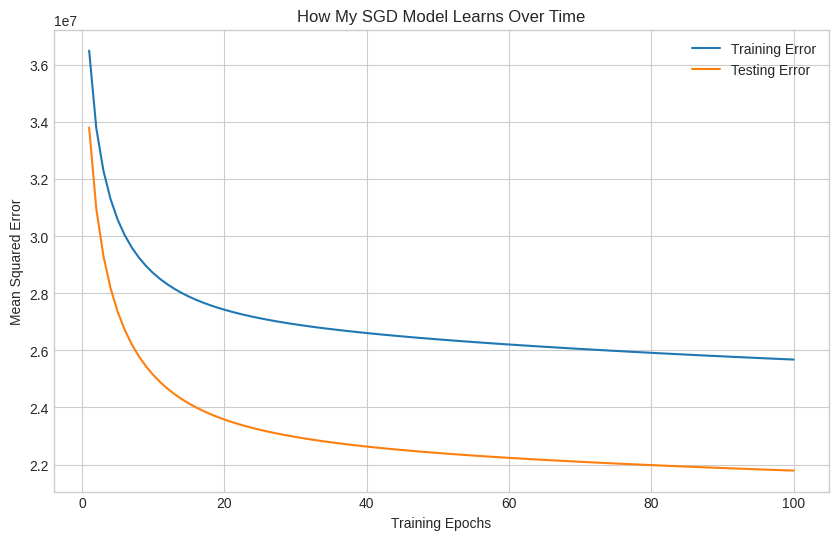

In [19]:
# Visualizing how my model learns over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_errors, label='Training Error')
plt.plot(range(1, n_epochs + 1), test_errors, label='Testing Error')
plt.xlabel('Training Epochs')
plt.ylabel('Mean Squared Error')
plt.title('How My SGD Model Learns Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Model 3: Decision Tree

In [20]:
# Building my decision tree pipeline
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', DecisionTreeRegressor(random_state=42))])

# Training the model
dt_pipeline.fit(X_train, y_train)

# Checking how well it performs
print("My Decision Tree Results:")
dt_train_mse, dt_test_mse, dt_train_r2, dt_test_r2 = evaluate_model(dt_pipeline, X_train, X_test, y_train, y_test)

My Decision Tree Results:
Training MSE: 244239.55
Testing MSE: 38925186.61
Training R²: 0.9983
Testing R²: 0.7493


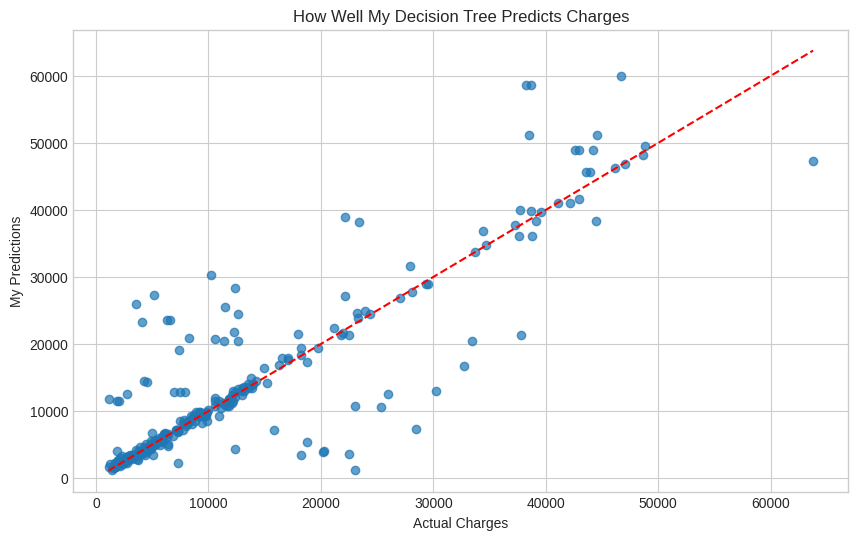

In [21]:
# Visualizing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_pipeline.predict(X_test), alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('My Predictions')
plt.title('How Well My Decision Tree Predicts Charges')
plt.show()

### Model 4: Random Forest

In [22]:
# Building my random forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Training the model
rf_pipeline.fit(X_train, y_train)

# Checking how well it performs
print("My Random Forest Results:")
rf_train_mse, rf_test_mse, rf_train_r2, rf_test_r2 = evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test)

My Random Forest Results:
Training MSE: 3747771.76
Testing MSE: 20855163.34
Training R²: 0.9740
Testing R²: 0.8657


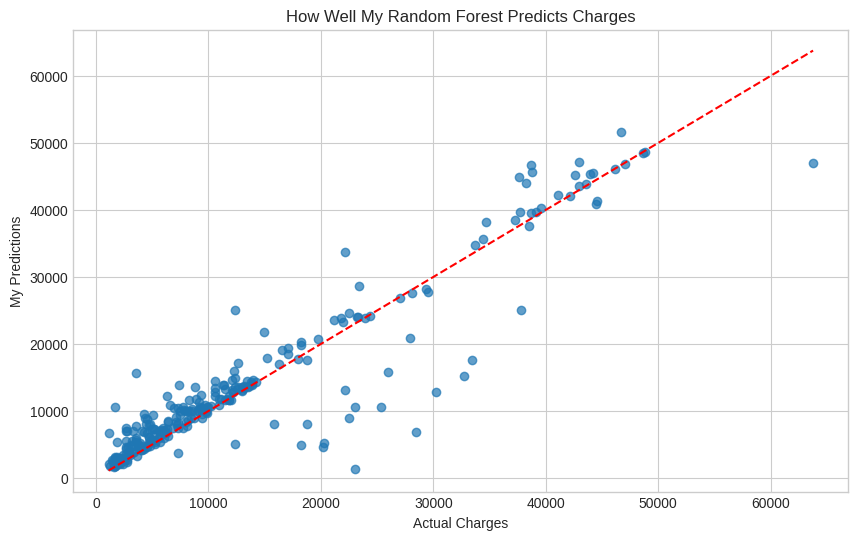

In [23]:
# Visualizing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pipeline.predict(X_test), alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('My Predictions')
plt.title('How Well My Random Forest Predicts Charges')
plt.show()

## Comparing My Models

In [24]:
# Putting all my results together
models = ['Linear Regression', 'SGD Regressor', 'Decision Tree', 'Random Forest']
train_mse_values = [lr_train_mse, sgd_train_mse, dt_train_mse, rf_train_mse]
test_mse_values = [lr_test_mse, sgd_test_mse, dt_test_mse, rf_test_mse]
train_r2_values = [lr_train_r2, sgd_train_r2, dt_train_r2, rf_train_r2]
test_r2_values = [lr_test_r2, sgd_test_r2, dt_test_r2, rf_test_r2]

# Creating a comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Train MSE': train_mse_values,
    'Test MSE': test_mse_values,
    'Train R²': train_r2_values,
    'Test R²': test_r2_values
})

comparison_df

,Model,Train MSE,Test MSE,Train R²,Test R²
0,Linear Regression,2.377699e+07,2.063710e+07,0.835264,0.867071
1,SGD Regressor,2.795342e+07,2.435400e+07,0.806328,0.843129
2,Decision Tree,2.442396e+05,3.892519e+07,0.998308,0.749272
3,Random Forest,3.747772e+06,2.085516e+07,0.974034,0.865666


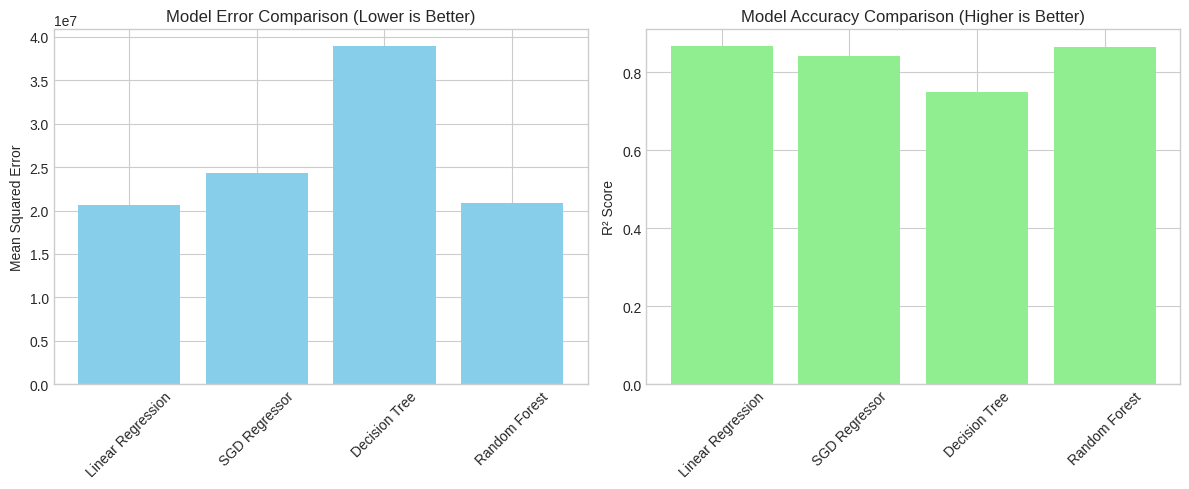

In [25]:
# Visualizing model comparison
plt.figure(figsize=(12, 5))

# Error comparison
plt.subplot(1, 2, 1)
plt.bar(models, test_mse_values, color='skyblue')
plt.title('Model Error Comparison (Lower is Better)')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.bar(models, test_r2_values, color='lightgreen')
plt.title('Model Accuracy Comparison (Higher is Better)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Selecting My Best Model

In [26]:
# Finding which model performed best
best_r2_idx = test_r2_values.index(max(test_r2_values))
best_model_name = models[best_r2_idx]
print(f"My best performing model is: {best_model_name}")

# Getting the best model
if best_model_name == 'Linear Regression':
    best_model = lr_pipeline
elif best_model_name == 'SGD Regressor':
    best_model = sgd_pipeline
elif best_model_name == 'Decision Tree':
    best_model = dt_pipeline
else:  # Random Forest
    best_model = rf_pipeline

# Saving my model for the API
joblib.dump(best_model, '../API/health_cost_model.pkl')
print(f"Model saved as 'health_cost_model.pkl'")

My best performing model is: Linear Regression
Model saved as 'health_cost_model.pkl'


## Creating My Prediction Function

In [27]:
# Function to make predictions with my best model
def predict_charges(age, sex, bmi, children, smoker, region):
    # Creating a DataFrame with the input data
    input_data = pd.DataFrame({
        'age': [age],
        'sex': [sex],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker],
        'region': [region]
    })
    
    # Adding my engineered features
    input_data['sex_numeric'] = input_data['sex'].map({'female': 0, 'male': 1})
    input_data['smoker_numeric'] = input_data['smoker'].map({'no': 0, 'yes': 1})
    input_data['smoker_bmi'] = input_data['smoker_numeric'] * input_data['bmi']
    input_data['smoker_age'] = input_data['smoker_numeric'] * input_data['age']
    input_data['bmi_squared'] = input_data['bmi'] ** 2
    
    # Removing temporary columns
    input_data = input_data.drop(['sex_numeric', 'smoker_numeric'], axis=1)
    
    # Making prediction
    prediction = best_model.predict(input_data)[0]
    
    return prediction

# Testing my prediction function
sample_prediction = predict_charges(
    age=30,
    sex='male',
    bmi=25.0,
    children=1,
    smoker='no',
    region='southwest'
)

print(f"My predicted health insurance cost: ${sample_prediction:.2f}")

My predicted health insurance cost: $5049.76


## What I've Learned and African Context Relevance

In this notebook, I've built and compared several models to predict health insurance costs based on personal health factors. My best performing model was saved for use in my API.

Key findings relevant to the African context simulation:

1. **Smoking's Huge Impact**: My models confirm that smoking dramatically increases health costs. This finding could support tobacco control initiatives in African countries where smoking rates are rising, especially among youth.

2. **BMI as a Cost Driver**: The relationship between BMI and health costs highlights the importance of nutrition education in regions experiencing nutrition transitions, where both undernutrition and obesity can coexist.

3. **Age-Related Cost Increases**: The strong correlation between age and costs emphasizes the need for age-appropriate healthcare planning in African countries with growing life expectancies.

4. **Compounding Risk Factors**: My engineered features (especially smoker*BMI and smoker*age) show how certain health risks multiply each other's effects - a crucial insight for designing targeted interventions.

My model can serve as an educational tool to help people understand how their lifestyle choices affect healthcare costs. In African contexts, where out-of-pocket healthcare spending can be financially devastating, this awareness could motivate healthier choices and better financial planning for health needs.